In [114]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import weather_and_time_functions as weather_time

In [108]:
pd.set_option('display.max_columns',None)
scaler = StandardScaler()

flight_df = pd.read_feather('data/v2_clean_flight')
flight_test_df = pd.read_feather('data/v1_clean_flight_test')
fuel_consumption_df = pd.read_feather('data/v1_clean_fuel_consumption')
passenger_df = pd.read_feather('data/v1_clean_passenger')

In [36]:
# def duration_to_rank(x):
#     if x == 'short':
#         return 0
#     elif x =='medium':
#         return 1
#     else:
#         return 2

# flight_df['flight_duration'] = flight_df['flight_duration'].apply(lambda x: duration_to_rank(x))
## Not significant to the final model of features. 

In [109]:
dep_hour = weather_time.obtain_depart_hour(flight_df)
arr_hour = weather_time.obtain_arrival_hour(flight_df)
flight_df['dep_hour'] = dep_hour
flight_df['arr_hour'] = arr_hour
flight_df.drop('hour',axis=1,inplace=True)

In [110]:
flight_df['day'] = pd.to_datetime(flight_df['fl_date'],yearfirst=True).dt.day
flight_df['month'] = flight_df['month'].astype(int)
flight_df['dep_hour'] = flight_df['dep_hour'].astype(int)
flight_df['arr_hour'] = flight_df['arr_hour'].astype(int)

In [111]:
num_cols = ['crs_elapsed_time','distance','month','arr_hour']
cat_cols = ['origin','dest','op_unique_carrier']
y_target = flight_df['arr_delay'].fillna(0)

In [135]:
one_hot = OneHotEncoder(sparse_output=False)

In [140]:
transformed_data = one_hot.fit_transform(flight_model[cat_cols])
encoded_data = pd.DataFrame(transformed_data, index=flight_model[cat_cols].index)
final_flight_model = pd.concat([flight_model,encoded_data],axis=1)
final_flight_model.drop(['origin','dest','op_unique_carrier'],axis=1,inplace=True)

In [141]:
x_train,x_test,y_train,y_test = train_test_split(final_flight_model,y_target,test_size=0.3)

In [ ]:
#Best parameter is learning_rate 0.1, max_depth 3, n_estimators 50. Took 65minutes to run!, gives r2 of ~0.013

# params = {
#     'max_depth': [3,4,5,6,7],
#     'learning_rate': [0.001,0.01,0.1],
#     'n_estimators': [50,70,100,200]
# }
# xgboost = xgb.XGBRegressor()
# regCV = GridSearchCV(estimator=xgboost,cv=5,param_grid=params)
# regCV.fit(x_train,y_train)
# regCV.best_params_ 

In [142]:
xgboost = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=3, n_estimators=50)
xgboost.fit(x_train,y_train)
y_pred = xgboost.predict(x_test)

In [143]:
print("R2 Score: ", r2_score(y_test,y_pred))
print("Mean Squared Error: ", mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: ", mean_squared_error(y_test,y_pred, squared=False))

R2 Score:  0.014017747437877315
Mean Squared Error:  2687.131711539157
Root Mean Squared Error:  51.83755117228395


<AxesSubplot: title={'center': 'XGBoost Model on Flight Arrival Delays'}, xlabel='Actual results', ylabel='Predicted results'>

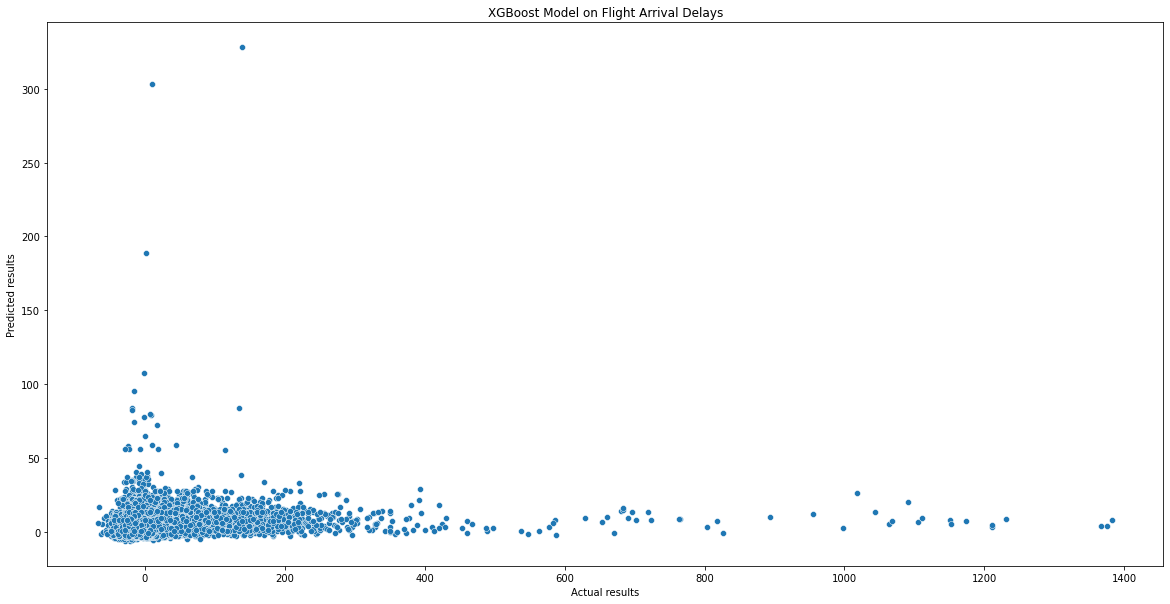

In [144]:
plt.figure(figsize=(20,10))
plt.xlabel('Actual results')
plt.ylabel('Predicted results')
plt.title('XGBoost Model on Flight Arrival Delays')
sns.scatterplot(x=y_test,y=y_pred)

# Sample Submission CSV Creation

In [96]:
flight_test_df

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance
0,2020-01-30,WN,2193,WN,N8642E,12191,HOU,"Houston, TX",13232,MDW,"Chicago, IL",1010,1235,145,937
1,2020-01-26,WN,3352,WN,N796SW,12992,LIT,"Little Rock, AR",15016,STL,"St. Louis, MO",1705,1810,65,296
2,2020-01-17,AS,365,AS,N584AS,14771,SFO,"San Francisco, CA",14057,PDX,"Portland, OR",2155,2344,109,550
3,2020-01-31,AA,3156,OO,N776SK,13930,ORD,"Chicago, IL",10372,ASE,"Aspen, CO",950,1214,204,1013
4,2020-01-25,WN,3762,WN,N8679A,14747,SEA,"Seattle, WA",13796,OAK,"Oakland, CA",1450,1655,125,672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2020-01-14,AA,5338,OH,N562NN,11057,CLT,"Charlotte, NC",11986,GRR,"Grand Rapids, MI",1622,1830,128,583
99996,2020-01-30,WN,2053,WN,N942WN,11292,DEN,"Denver, CO",15016,STL,"St. Louis, MO",2000,2255,115,770
99997,2020-01-06,WN,5757,WN,N923WN,14492,RDU,"Raleigh/Durham, NC",13204,MCO,"Orlando, FL",1730,1915,105,534
99998,2020-01-16,AA,1704,AA,N651AW,15304,TPA,"Tampa, FL",11057,CLT,"Charlotte, NC",813,1007,114,507


In [146]:
dep_hour = weather_time.obtain_depart_hour(flight_test_df)
arr_hour = weather_time.obtain_arrival_hour(flight_test_df)
flight_test_df['dep_hour'] = dep_hour
flight_test_df['arr_hour'] = arr_hour


In [147]:
flight_test_df['month'] = pd.to_datetime(flight_test_df['fl_date'],yearfirst=True).dt.month
flight_test_df['day'] = pd.to_datetime(flight_test_df['fl_date'],yearfirst=True).dt.day
flight_test_df['month'] = flight_test_df['month'].astype(int)
flight_test_df['dep_hour'] = flight_test_df['dep_hour'].astype(int)
flight_test_df['arr_hour'] = flight_test_df['arr_hour'].astype(int)

In [151]:
flight_test_model = flight_test_df[['crs_elapsed_time','distance','month','arr_hour','origin','dest','op_unique_carrier']]
flight_test_model

,crs_elapsed_time,distance,month,arr_hour,origin,dest,op_unique_carrier
0,145,937,1,12,HOU,MDW,WN
1,65,296,1,18,LIT,STL,WN
2,109,550,1,23,SFO,PDX,AS
3,204,1013,1,12,ORD,ASE,OO
4,125,672,1,16,SEA,OAK,WN
...,...,...,...,...,...,...,...
99995,128,583,1,18,CLT,GRR,OH
99996,115,770,1,22,DEN,STL,WN
99997,105,534,1,19,RDU,MCO,WN
99998,114,507,1,10,TPA,CLT,AA


In [152]:
transformed_data = one_hot.fit_transform(flight_test_model[cat_cols])
encoded_data = pd.DataFrame(transformed_data, index=flight_test_model[cat_cols].index)
final_flight_model = pd.concat([flight_test_model,encoded_data],axis=1)
final_flight_model.drop(['origin','dest','op_unique_carrier'],axis=1,inplace=True)

In [154]:
final_flight_model

,crs_elapsed_time,distance,month,arr_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747
0,145,937,1,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [155]:
unk_pred = xgboost.predict(final_flight_model)

ValueError: Feature shape mismatch, expected: 773, got 752